In [8]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from src.fileutils import PROJECT_ROOT, MODELS_DIR
from src.camera.video import VideoStream
from src.pose.orientation_estimation import OrientationEstimation
from src.segmentation.yolo_detector import SplitYoloDetector
from src.segmentation.split_image import ImageSplitter
from ultralytics import YOLOWorld

In [10]:
model_path = PROJECT_ROOT / "models" / "doe" / "spindoe.ckpt"
use_gpu = False
orientation_estimator = OrientationEstimation(model_path, use_gpu, doe_expected_brightness=55)

Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\models\doe\spindoe.ckpt`


Saving hyperparmeters
DOE  initiated


In [11]:
rolling_video_path = PROJECT_ROOT / "data" / "orientation_images" / "rolling.mp4"
rolling_video = VideoStream(rolling_video_path)
print(rolling_video)

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\orientation_images\rolling.mp4
	FPS: 30.0
	Frames: 51
	Resolution: 1920x1080



In [12]:
# Init YOLO World
model = YOLOWorld(str(MODELS_DIR / "yolo" / 'yolov8l-world.pt'))
model.set_classes(['person', 'sports ball', 'ball'])
ball_classes = {1, 2}

model.conf = 0.1
model.iou = 0.1

split_height = rolling_video.height // 3
split_width = rolling_video.width // 3
overlap = 0.3
splitter = ImageSplitter(split_height=split_height, split_width=split_width, overlap=overlap)
detector = SplitYoloDetector(model, splitter, ball_classes=ball_classes)

In [13]:
model_path = MODELS_DIR / "doe" / "spindoe.ckpt"
use_gpu = False
orientation_estimator = OrientationEstimation(model_path, use_gpu, doe_expected_brightness=55)

Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\models\doe\spindoe.ckpt`


Saving hyperparmeters
DOE  initiated



0: 384x640 (no detections), 6113.2ms
Speed: 154.1ms preprocess, 6113.2ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4313.1ms
Speed: 5.9ms preprocess, 4313.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4042.0ms
Speed: 6.2ms preprocess, 4042.0ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3322.4ms
Speed: 11.7ms preprocess, 3322.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3668.2ms
Speed: 7.0ms preprocess, 3668.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4487.3ms
Speed: 7.4ms preprocess, 4487.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 ball, 4644.7ms
Speed: 15.3ms preprocess, 4644.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 35

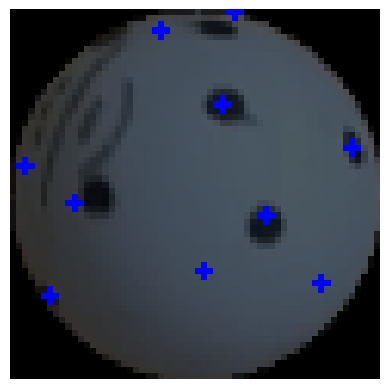

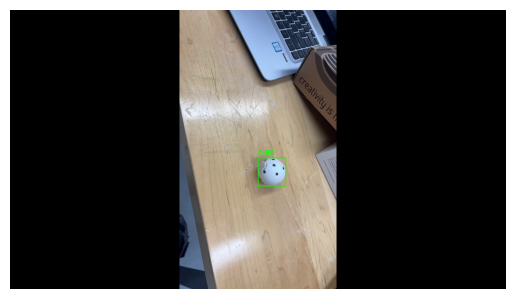


0: 384x640 (no detections), 2762.6ms
Speed: 0.0ms preprocess, 2762.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2298.4ms
Speed: 3.0ms preprocess, 2298.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2411.0ms
Speed: 8.7ms preprocess, 2411.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2349.6ms
Speed: 11.8ms preprocess, 2349.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2329.0ms
Speed: 4.0ms preprocess, 2329.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1968.4ms
Speed: 2.0ms preprocess, 1968.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1837.8ms
Speed: 5.0ms preprocess, 1837.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2573.0ms
Spee

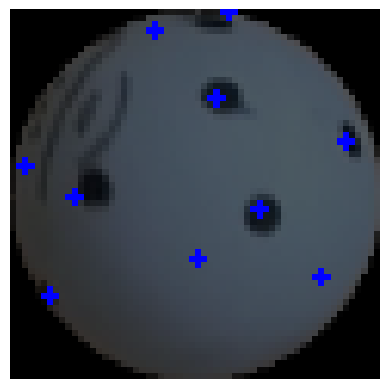

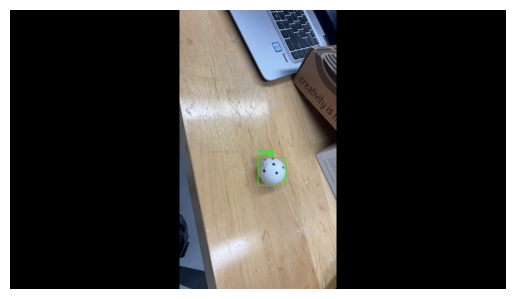


0: 384x640 (no detections), 3002.4ms
Speed: 15.6ms preprocess, 3002.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2267.0ms
Speed: 8.2ms preprocess, 2267.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1869.1ms
Speed: 5.3ms preprocess, 1869.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2285.1ms
Speed: 0.0ms preprocess, 2285.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2515.4ms
Speed: 0.0ms preprocess, 2515.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3093.9ms
Speed: 4.5ms preprocess, 3093.9ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 2681.1ms
Speed: 4.0ms preprocess, 2681.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2577.0ms
Spee

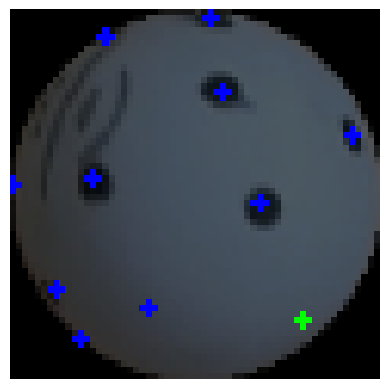

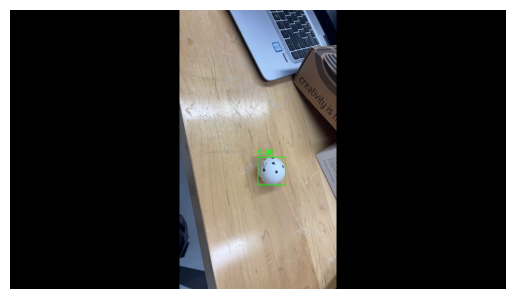


0: 384x640 (no detections), 2355.3ms
Speed: 2.7ms preprocess, 2355.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2655.2ms
Speed: 2.0ms preprocess, 2655.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2533.2ms
Speed: 0.0ms preprocess, 2533.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2514.0ms
Speed: 5.7ms preprocess, 2514.0ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2498.7ms
Speed: 10.1ms preprocess, 2498.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2645.6ms
Speed: 0.0ms preprocess, 2645.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 2628.4ms
Speed: 8.1ms preprocess, 2628.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 3411.5ms
Speed:

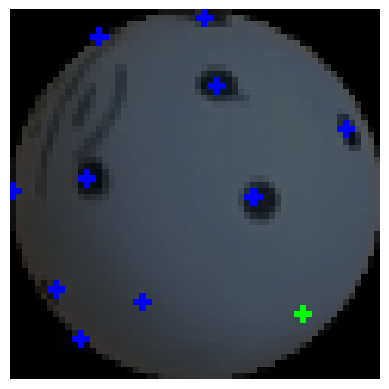

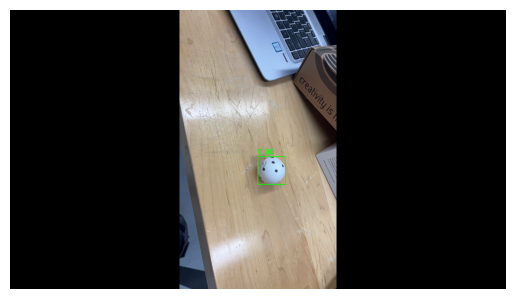


0: 384x640 (no detections), 2761.8ms
Speed: 6.1ms preprocess, 2761.8ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2773.4ms
Speed: 8.1ms preprocess, 2773.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2755.8ms
Speed: 4.8ms preprocess, 2755.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2538.7ms
Speed: 8.1ms preprocess, 2538.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2738.7ms
Speed: 4.0ms preprocess, 2738.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3212.7ms
Speed: 10.1ms preprocess, 3212.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 3148.5ms
Speed: 10.8ms preprocess, 3148.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 3357.1ms
Speed

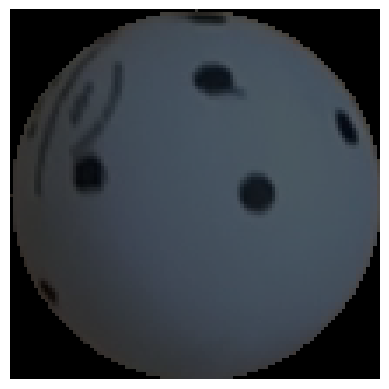

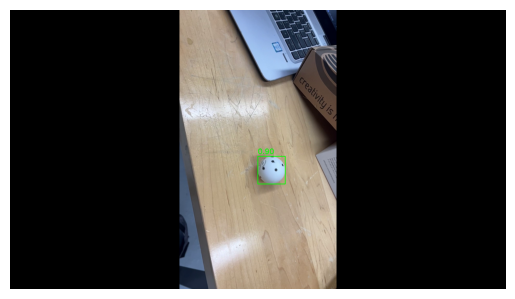


0: 384x640 (no detections), 2765.3ms
Speed: 15.7ms preprocess, 2765.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3032.3ms
Speed: 4.4ms preprocess, 3032.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2614.1ms
Speed: 6.4ms preprocess, 2614.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2692.2ms
Speed: 10.1ms preprocess, 2692.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7169.8ms
Speed: 9.6ms preprocess, 7169.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5956.0ms
Speed: 23.7ms preprocess, 5956.0ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 ball, 5442.3ms
Speed: 18.3ms preprocess, 5442.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 ba

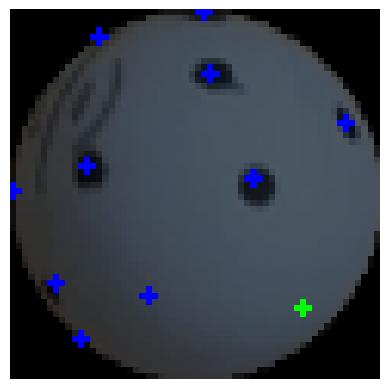

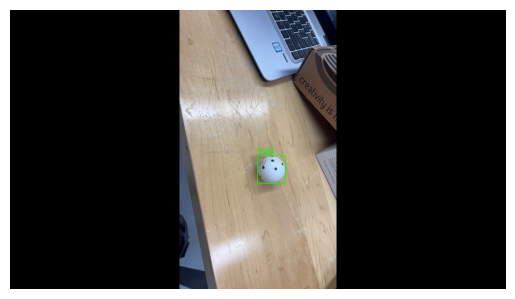


0: 384x640 (no detections), 2873.9ms
Speed: 15.2ms preprocess, 2873.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3967.3ms
Speed: 4.9ms preprocess, 3967.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3333.1ms
Speed: 12.3ms preprocess, 3333.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4693.7ms
Speed: 8.1ms preprocess, 4693.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3041.0ms
Speed: 4.0ms preprocess, 3041.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2377.1ms
Speed: 5.1ms preprocess, 2377.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 ball, 2494.4ms
Speed: 14.2ms preprocess, 2494.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 2392.

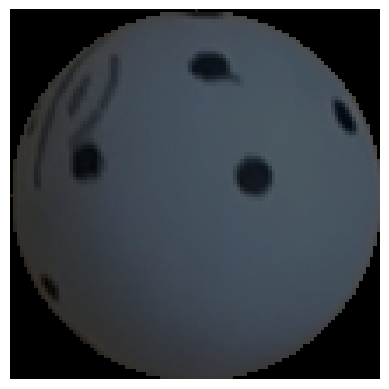

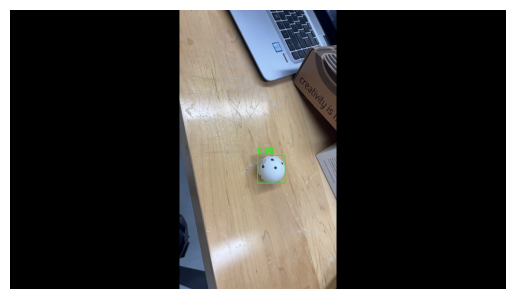


0: 384x640 (no detections), 5081.6ms
Speed: 17.6ms preprocess, 5081.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5128.7ms
Speed: 3.0ms preprocess, 5128.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5301.1ms
Speed: 10.7ms preprocess, 5301.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5770.3ms
Speed: 7.2ms preprocess, 5770.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8737.3ms
Speed: 8.2ms preprocess, 8737.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9567.6ms
Speed: 4.0ms preprocess, 9567.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 ball, 5207.5ms
Speed: 7.1ms preprocess, 5207.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 7180.5

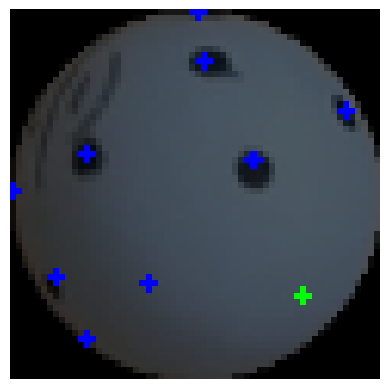

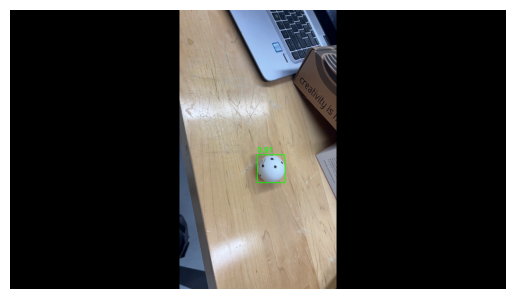


0: 384x640 (no detections), 6703.8ms
Speed: 30.3ms preprocess, 6703.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6551.7ms
Speed: 6.0ms preprocess, 6551.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5285.2ms
Speed: 4.2ms preprocess, 5285.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6121.6ms
Speed: 37.5ms preprocess, 6121.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4498.2ms
Speed: 20.1ms preprocess, 4498.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4003.3ms
Speed: 20.2ms preprocess, 4003.3ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 ball, 3941.1ms
Speed: 8.0ms preprocess, 3941.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 ba

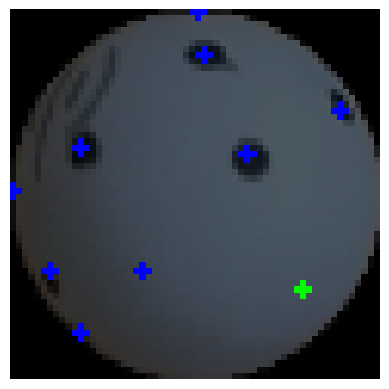

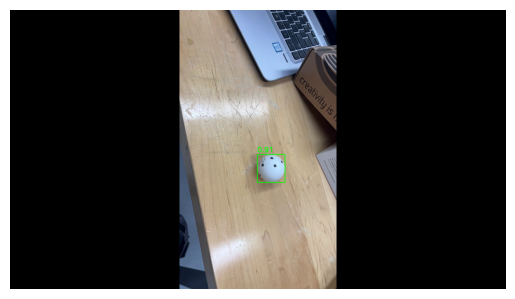


0: 384x640 (no detections), 3588.1ms
Speed: 8.0ms preprocess, 3588.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3978.0ms
Speed: 10.1ms preprocess, 3978.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3919.5ms
Speed: 14.4ms preprocess, 3919.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3931.1ms
Speed: 10.2ms preprocess, 3931.1ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3980.9ms
Speed: 16.1ms preprocess, 3980.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5207.9ms
Speed: 7.0ms preprocess, 5207.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 ball, 3791.0ms
Speed: 41.6ms preprocess, 3791.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 361

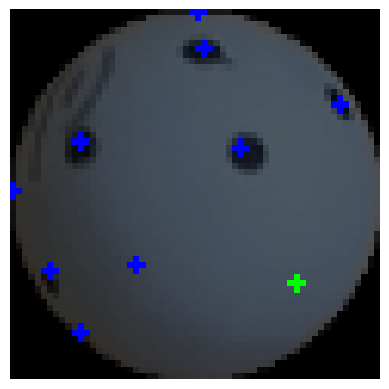

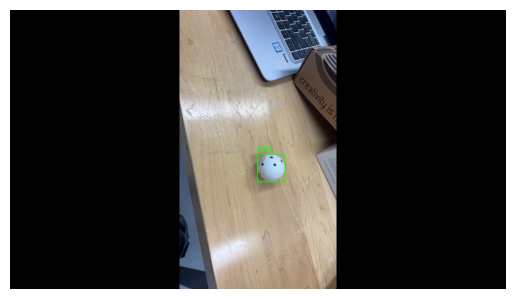


0: 384x640 (no detections), 3985.9ms
Speed: 5.3ms preprocess, 3985.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3409.9ms
Speed: 4.0ms preprocess, 3409.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3459.9ms
Speed: 5.0ms preprocess, 3459.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3503.4ms
Speed: 3.0ms preprocess, 3503.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2214.3ms
Speed: 5.2ms preprocess, 2214.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2016.7ms
Speed: 4.4ms preprocess, 2016.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1931.8ms
Speed: 0.0ms preprocess, 1931.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1766.9ms
Speed: 

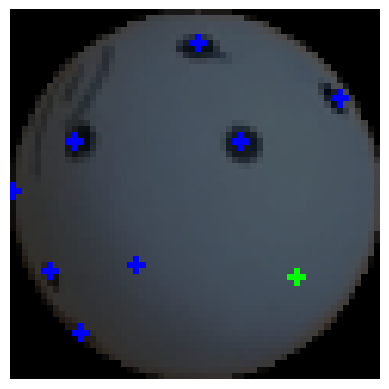

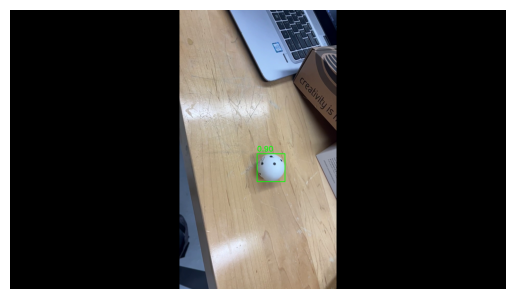


0: 384x640 (no detections), 1942.1ms
Speed: 3.0ms preprocess, 1942.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2347.9ms
Speed: 2.5ms preprocess, 2347.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1718.6ms
Speed: 4.3ms preprocess, 1718.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1929.2ms
Speed: 7.2ms preprocess, 1929.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2329.2ms
Speed: 5.9ms preprocess, 2329.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5192.2ms
Speed: 1.6ms preprocess, 5192.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 4304.5ms
Speed: 45.7ms preprocess, 4304.5ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 3774.4ms
Speed:

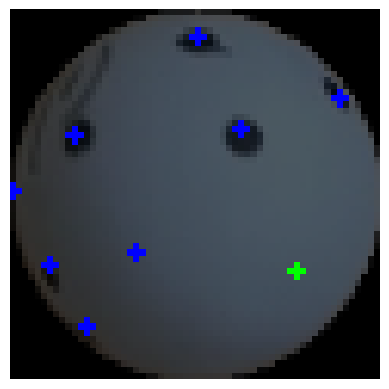

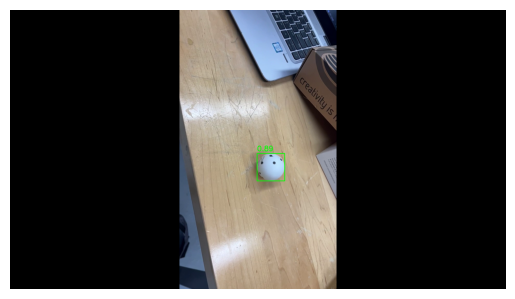


0: 384x640 (no detections), 4734.2ms
Speed: 15.6ms preprocess, 4734.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1724.0ms
Speed: 2.5ms preprocess, 1724.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2379.2ms
Speed: 0.0ms preprocess, 2379.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2339.8ms
Speed: 5.0ms preprocess, 2339.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3947.3ms
Speed: 4.4ms preprocess, 3947.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3945.6ms
Speed: 6.3ms preprocess, 3945.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 4206.2ms
Speed: 11.1ms preprocess, 4206.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 3850.5ms
Speed

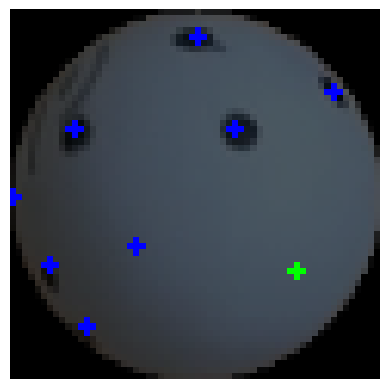

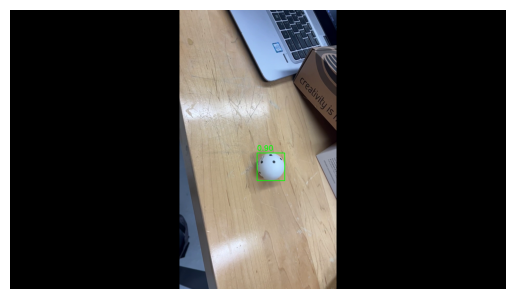


0: 384x640 (no detections), 2819.6ms
Speed: 1.7ms preprocess, 2819.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2815.1ms
Speed: 8.2ms preprocess, 2815.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2758.9ms
Speed: 5.7ms preprocess, 2758.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2692.8ms
Speed: 5.1ms preprocess, 2692.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2813.0ms
Speed: 3.0ms preprocess, 2813.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2749.2ms
Speed: 4.7ms preprocess, 2749.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 3204.7ms
Speed: 5.5ms preprocess, 3204.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 4435.5ms
Speed: 

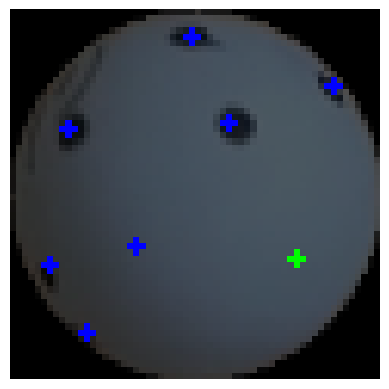

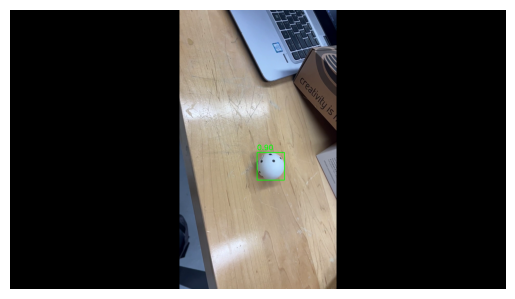


0: 384x640 (no detections), 8639.3ms
Speed: 24.2ms preprocess, 8639.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7168.9ms
Speed: 32.1ms preprocess, 7168.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7701.3ms
Speed: 49.7ms preprocess, 7701.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3005.7ms
Speed: 4.8ms preprocess, 3005.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3013.3ms
Speed: 7.1ms preprocess, 3013.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4143.1ms
Speed: 7.0ms preprocess, 4143.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 3669.4ms
Speed: 3.0ms preprocess, 3669.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 2033.6ms
Spee

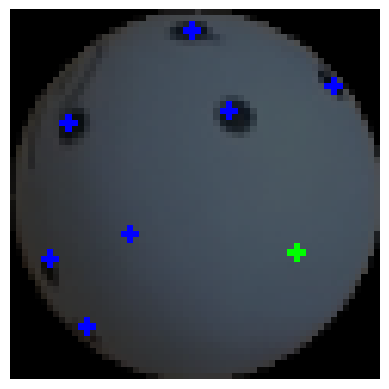

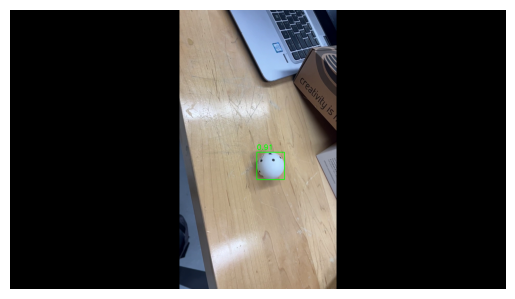


0: 384x640 (no detections), 13445.1ms
Speed: 90.0ms preprocess, 13445.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4086.4ms
Speed: 27.7ms preprocess, 4086.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3711.4ms
Speed: 8.0ms preprocess, 3711.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3337.5ms
Speed: 7.0ms preprocess, 3337.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3994.3ms
Speed: 66.9ms preprocess, 3994.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4335.1ms
Speed: 21.4ms preprocess, 4335.1ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 4102.7ms
Speed: 6.0ms preprocess, 4102.7ms inference, 17.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 3576.4ms


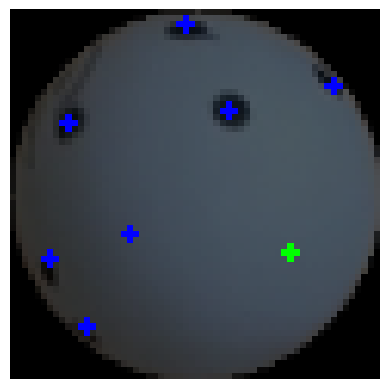

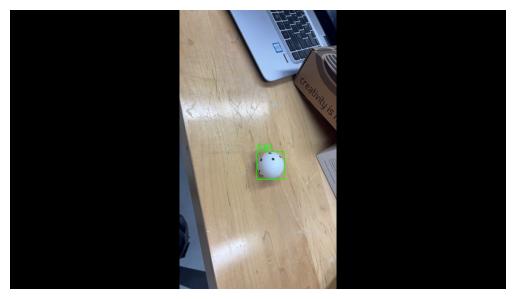


0: 384x640 (no detections), 5708.4ms
Speed: 20.9ms preprocess, 5708.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5466.6ms
Speed: 43.8ms preprocess, 5466.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3362.8ms
Speed: 44.7ms preprocess, 3362.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3817.4ms
Speed: 7.0ms preprocess, 3817.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3726.8ms
Speed: 6.0ms preprocess, 3726.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3162.0ms
Speed: 8.0ms preprocess, 3162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 2783.2ms
Speed: 11.2ms preprocess, 2783.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 ball, 2462

In [14]:
annotated_frames = []
rots = []
aug_imgs = []

for frame in rolling_video:

    box, conf = detector.detect(frame, yolo_verbose = True, debug_plots = False)
    annotated_frame = frame.copy()

    if box is not None:
        print(f"Bounding box {box} detected with confidence {conf}")
        detector.draw_bounding_box(annotated_frame, box, conf)

        # Crop the ball from the frame
        cropped_ball = frame[box[1]:box[3], box[0]:box[2]]
        print(cropped_ball.shape)

        # Estimate the orientation of the ball
        rot, preprocessed_img, aug_img, heatmap = orientation_estimator.estimate_orientation_with_doe_debug(
                image=cropped_ball,
                ball_mask=None,
                ball_center_x=cropped_ball.shape[1]//2,
                ball_center_y=cropped_ball.shape[0]//2,
                ball_radius=min(cropped_ball.shape[0]//2, cropped_ball.shape[1]//2),
            )
        
        if rot is not None:
            print(f"Estimated rotation: {rot.as_euler('xyz', degrees=True)} degrees")
        rots.append(rot)
        aug_imgs.append(aug_img)
        print(aug_img.shape)

        plt.figure()
        plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    else:
        print("No ball detected")

    # Display the image with detected circles
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    annotated_frames.append(annotated_frame)

In [ ]:
# Get the dimensions of the first image
height, width, _ = annotated_frames[0].shape

# Create a VideoWriter object to save the stitched video
output_path = 'stitched_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (width, height))

# Write each frame to the video
for frame in annotated_frames:
    out.write(frame)

# Release the VideoWriter object
out.release()

print(f"Stitched video saved at {output_path}")


In [ ]:
# Stich the augmented images together
aug_img_height, aug_img_width, _ = aug_imgs[0].shape

# Create a VideoWriter object to save the stitched video
output_path = 'augmented_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (aug_img_width, aug_img_height))

# Write each frame to the video
for frame in aug_imgs:
    out.write(frame)

# Release the VideoWriter object
out.release()

print(f"Augmented video saved at {output_path}")